## Regression
We will try to predict the percentage of votes won by Bill Clinton in the 1992
election.

In [1]:
import pandas as pd
%pylab inline

import statsmodels.api as sm
from patsy import dmatrices

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### [Q1 8 points] Read the data.
Read in the data from the file `clinton1.dat`. 
Note that this is NOT a CSV file.
The description of the data fields are present in `clinton1.txt`.
You will have to figure out the right parameters for the read csv command yourself (e.g., the regular expression for the delimiter, and the names of the columns).

*Note*: The dataset is from http://www.stat.ufl.edu/~winner/data/

In [15]:
clinton1 = pd.read_csv("clinton1.dat",
                      sep = "\s\s+",
                      header = None,
                      names = ["CountyName", "percentVoting", \
                              "MedianAge", "MeanSavings", "PerCapitaIncome", \
                              "PercentPoverty", "PercentVeterans", "PercentFemale", \
                              "PopulationDensity", "PercentNursingHomes", "CrimeIndex"],
                      engine = "python")
clinton1

,CountyName,percentVoting,MedianAge,MeanSavings,PerCapitaIncome,PercentPoverty,PercentVeterans,PercentFemale,PopulationDensity,PercentNursingHomes,CrimeIndex
0,"Autauga, AL",30.92,31.7,57623,15768,15.2,10.74,51.41,60.4,2.36,457
1,"Baldwin, AL",26.24,35.5,84935,16954,13.6,9.73,51.34,66.5,5.40,282
2,"Barbour, AL",46.36,32.8,83656,15532,25.0,8.82,53.03,28.8,7.02,47
3,"Blount, AL",32.92,34.5,61249,14820,15.0,9.67,51.15,62.4,2.36,185
4,"Bullock, AL",67.67,31.7,75725,11120,33.0,7.08,50.76,17.6,2.91,141
...,...,...,...,...,...,...,...,...,...,...,...
2699,"Sheridan, WY",35.81,36.3,87232,22250,11.6,16.59,50.73,9.5,4.67,275
2700,"Sublette, WY",20.83,35.4,83020,18748,7.9,12.18,47.98,1.0,8.60,432
2701,"Sweetwater, WY",43.09,30.4,104346,19086,7.7,14.64,49.42,3.9,3.00,625
2702,"Washakie, WY",28.08,34.6,114176,17608,11.7,14.47,49.65,3.8,8.47,313


### [Q2 8 points] Predict percentVoting on all regressors.
One of the fields in the data is “Percent voting for Clinton in 1992”; let’s call it `percentVoting`.
Regress `percentVoting` on all available regressors.
Which two regressors have the worst p-values?

In [16]:
y, X = dmatrices("percentVoting ~ MedianAge + MeanSavings + PerCapitaIncome + PercentPoverty + PercentVeterans + PercentFemale + PopulationDensity + PercentNursingHomes + CrimeIndex", data = clinton1, return_type = "dataframe")
model = sm.OLS(y, X)
result = model.fit()
result.pvalues.sort_values(ascending = False)[:2]

MedianAge     0.238619
CrimeIndex    0.141950
dtype: float64


### [Q3 8 points] A formula-creating function.
Write a function called `formula` that
* takes a list of regressors as input, and
* outputs the formula for regressing `percentVoting` on these regressors.

For example:
<pre>formula(['age', 'savings'])</pre>
should output
<pre>percentVoting ∼ age + savings</pre>

In [17]:
def formula(s):
    formula = "percentVoting ~ "
    for index, variable in enumerate(s):
        if index + 1 < len(s):
            formula += variable + " + "
        else:
            formula += variable
    return formula

### [Q4 8 points] R-squared computation function.
Write a function called `rsquared` that with the following properties:
* **Input:** a list of regressors (e.g., `['age', 'savings']`),
* **Output:** the R-squared of a regression of `percentVoting` with respect to the list of regressors. 

You can use the `formula` function you wrote above.

* Show the output of `rsquared` with the input being `['age']`

In [18]:
def rsquared(s):
    y, X = dmatrices(formula(s), data = clinton1, return_type = "dataframe")
    model = sm.OLS(y, X)
    result = model.fit()
    return result.rsquared

rsquared(["MedianAge"])

0.0033799834005024953

### [Q5 8 points] Find the next best regressor.
Write a function called `best_next_regressor` with the following properties:
* **Inputs:**
    * a list of regressors (called `current_regressors`), and
    * the list of all possible regressors (called `all_regressors`)
* **What it does:** For every regressor `x` from the `all_regressors` list that, calculate the R-square if you regressed `percentVoting` using `x` AND all the regressors in `current_regressors`.
* **Output:** Return the regressor `x` that gives the highest R-square value above. Also, return this R-square value.
* Show the output of `best_next_regressor` with `current_regressors=[]`

In [19]:
def best_next_regressor(current_regressors, all_regressors):
    highestr2 = 0
    highestregg = ""
    for regg in all_regressors:
        temp = current_regressors.copy()
        temp.append(regg)
        tempr2 = rsquared(temp)
        if tempr2 > highestr2:
            highestr2 = tempr2
            highestregg = regg
    return highestregg, highestr2

best_next_regressor([], clinton1.columns.tolist()[2:])

('PercentPoverty', 0.2510385196163196)

### [Q6 8 points] Pick the k best regressors.
Write a function called `best_regressors` that has the following properties:
* **Inputs:**
    * `k`, which is the number of regressors we want (e.g., `k=3`), and
    * `all_regressors`, which again is the list of all possible regressors.
* **What it does:** The function `best_regressors` should compute the best `k` regressors by picking them one at a time using the `best_next_regressor` function from Q5.
* **Outputs:** The function should return a tuple of the following items:
    * a list of the best regressors, in the order in which they were picked, and
    * the corresponding R-square values.
    
In other words, the output should be a list of the results of calling `best_next_regressor.`
* Show the output of `best_regressors` with `k=3`.

In [20]:
def best_regressors(k, all_regressors):
    best_list_names = []
    best_list = []
    for x in range(k):
        next_best = best_next_regressor(best_list_names, all_regressors)
        all_regressors.remove(next_best[0])
        best_list_names.append(next_best[0])
        best_list.append(next_best)
    return best_list
best_regressors(3, clinton1.columns.tolist()[2:])

[('PercentPoverty', 0.2510385196163196),
 ('PopulationDensity', 0.2858298022910579),
 ('PercentFemale', 0.30914506632485783)]

### [Q7 8 points] Order all regressors in the best order.
Run `best_regressors` to output all available regressors in sequence.
* **Outputs:** The first item in the result should be the best single regressor. The second item should be the next best regressor that combined with the first regressor gives the best R-square, and so on.

This idea of ordering the regressors in this particular order is called **forward selection**, and is one way of selecting only a few regressors when given a large set of regressors.

In [21]:
order_regg = best_regressors(9, clinton1.columns.tolist()[2:])
order_regg

[('PercentPoverty', 0.2510385196163196),
 ('PopulationDensity', 0.2858298022910579),
 ('PercentFemale', 0.30914506632485783),
 ('MeanSavings', 0.31924118502370513),
 ('PercentVeterans', 0.32299256887291694),
 ('PercentNursingHomes', 0.3248512713869368),
 ('PerCapitaIncome', 0.32582492389958884),
 ('CrimeIndex', 0.32655325570492566),
 ('MedianAge', 0.32690038725174053)]

### [Q8 8 points] Plot the R-squared values as regressors are added in the best order.

<AxesSubplot: xlabel='Regressor', ylabel='r^2'>

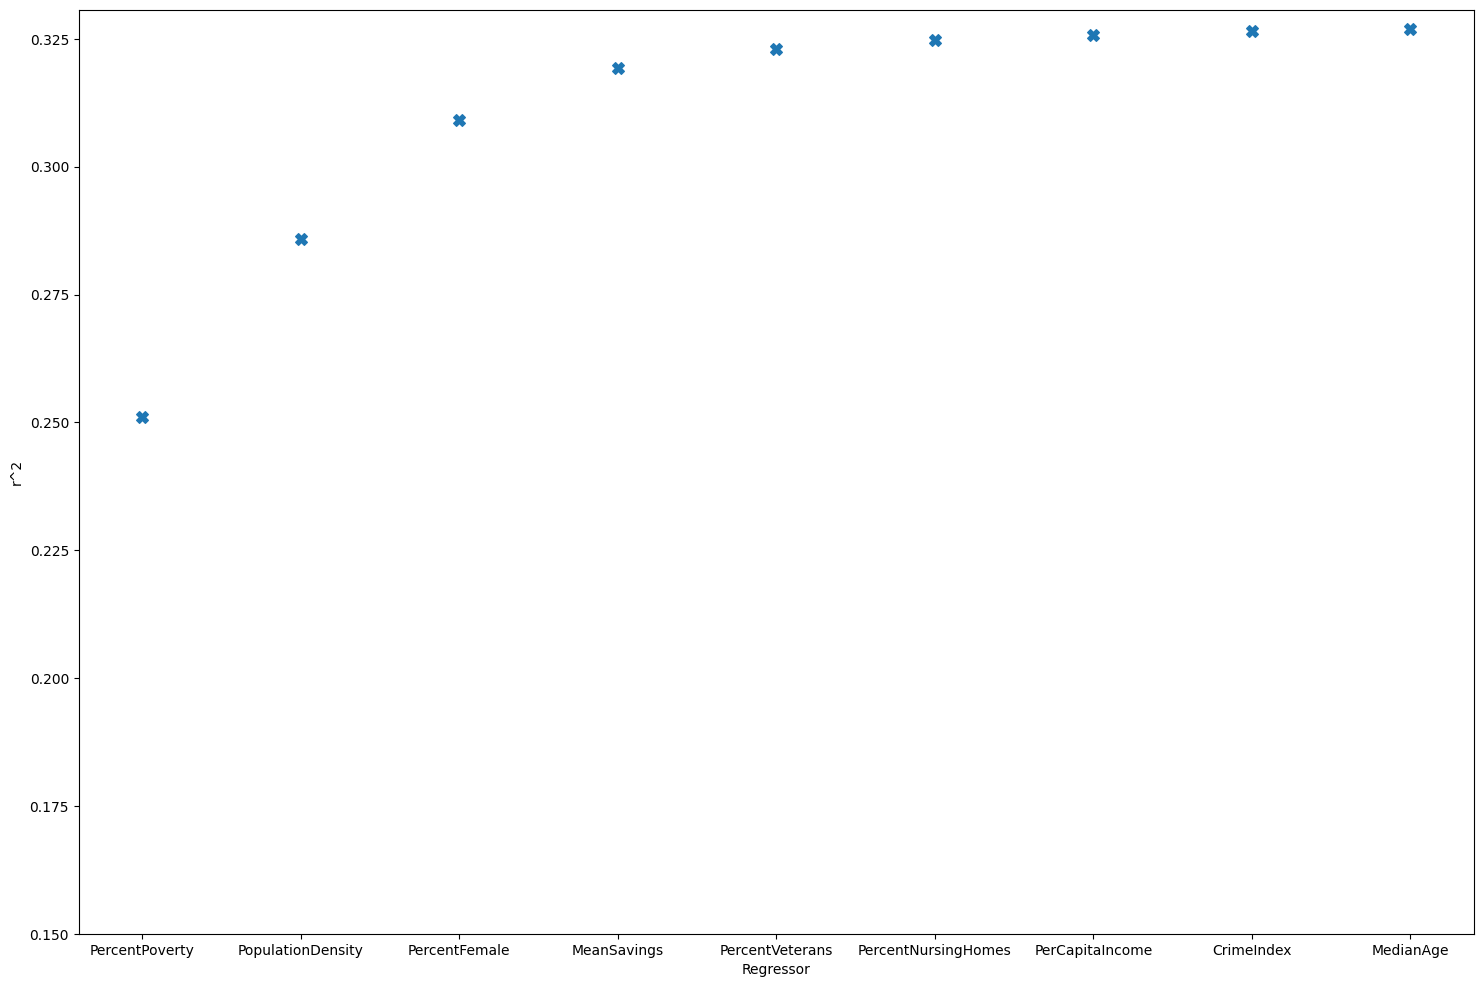

In [22]:
dfq8 = pd.DataFrame(order_regg, columns = ["Regressor", "r^2"])
dfq8.plot.scatter("Regressor", "r^2", s = 70, marker = "X", figsize = (18, 12), ylim = .15)

---
# K-Nearest Neighbors Classification
We will work with the same dataset as above.

### [Q9 8 points] Create a classification target.
Attach a new column, called `target` to the DataFrame, whose value for each row is either 1 (if `percentVoting` is at least 40.0), or 0 (if `percentVoting` is less than 40.0).

In [23]:
def classify_1or0(s):
    if s > 40.0:
        return 1
    else:
        return 0
clinton1["target"] = clinton1["percentVoting"].map(classify_1or0)

### [Q10 8 points] Create training and test sets.
* Create design matrices for predicting the `target` using just two features: `poverty` and `popdensity`.
* Split this into design matrices for training and testing datasets, with 70% data being used for training, and 30% for testing.

In [24]:
from sklearn.model_selection import train_test_split

Y1, X1 = dmatrices("target ~ 0 + PercentPoverty + PopulationDensity", clinton1, return_type = "dataframe")
y1 = Y1["target"].values

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.3, random_state = 1)

### [Q11 12 points] Accuracy of classification.
* Use a K-nearest neighbors classifier to predict the target using the two given features, using 1, 3, 5, 10, 20, 50, 100, and 1000 nearest neighbors respectively.
* Print out the training and test accuracy for each of these.

In [25]:
from sklearn import neighbors, metrics

def neighbors_prediction(num_neighbors):
    model = neighbors.KNeighborsClassifier(n_neighbors = num_neighbors, weights='uniform', p=2)
    model.fit(X1_train, y1_train)
    prediction_on_training = model.predict(X1_train)
    prediction_on_testing = model.predict(X1_test)
    
    return (metrics.accuracy_score(y1_train, prediction_on_training), metrics.accuracy_score(y1_test, prediction_on_testing))

for x in [1, 3, 5, 10, 20, 50, 100, 1000]:
    pred_training, pred_test = neighbors_prediction(x)
    print("# of Nearest Neighbors:", x, "|", "Training Accuracy:", pred_training, "|", pred_test)

# of Nearest Neighbors: 1 | Training Accuracy: 0.9978858350951374 | 0.6009852216748769
# of Nearest Neighbors: 3 | Training Accuracy: 0.7885835095137421 | 0.6342364532019704
# of Nearest Neighbors: 5 | Training Accuracy: 0.75 | 0.6305418719211823
# of Nearest Neighbors: 10 | Training Accuracy: 0.7214587737843552 | 0.6477832512315271
# of Nearest Neighbors: 20 | Training Accuracy: 0.6908033826638478 | 0.6588669950738916
# of Nearest Neighbors: 50 | Training Accuracy: 0.6844608879492601 | 0.6613300492610837
# of Nearest Neighbors: 100 | Training Accuracy: 0.6781183932346723 | 0.6650246305418719
# of Nearest Neighbors: 1000 | Training Accuracy: 0.5665961945031712 | 0.5701970443349754


### [Q12 8 points] Plots and reasons.
Show a scatter plot of `popdensity` versus `poverty`, and color the points according to the `target` (i.e., each point in the scatter plot represents a county, and the color of the county depends on the value of target for that county).

Can you interpret the plot? What types of counties voted for Bill Clinton?

Text(0, 0.5, 'Percent Poverty')

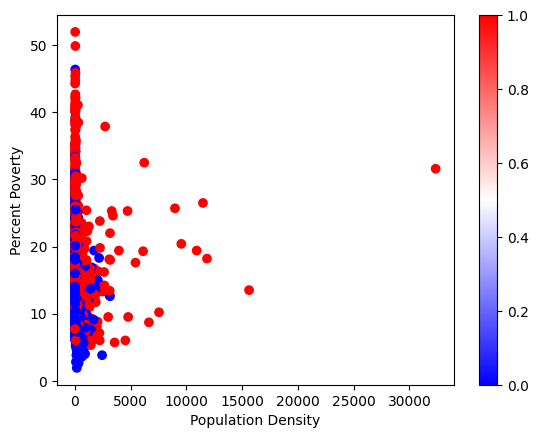

In [26]:
sc = scatter(X1["PopulationDensity"], X1["PercentPoverty"], c = y1, cmap = "bwr")
colorbar(sc)
xlabel("Population Density")
ylabel("Percent Poverty")


Looking at the plot, there is a much larger clustering of red dots (voted for Clinton) the higher in counties with higher poverty percentages.
Furthermore, counties with higher population densities also seemed to vote for Clinton.